In [ ]:
import numpy as np 
import os

import math
import warnings
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import pandas as pd

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
df = pd.read_json('dataset.json')
df.head()

,english,akan
0,What she lacks in charisma she makes up for wi...,Nea onni ho adwempa no de adwumaden na ɛba.
1,There was nothing I could do about it.,Na biribiara nni hɛ a metumi ayɔ
2,Kwaku saw John and Abena holding hands.,Kwaku hui se John ne Abena kurakura wɛn nsa.
3,Can you stay till 2:30?,So wubetumi atena ha akosi nnɛnmienu npaamu ad...
4,You haven't got much time.,Wonni mmre


SIMPLE WORD LEVEL TOKENIZER

In [ ]:
# WordLevelTokenizer class definition for simplicity
class WordLevelTokenizer:
    def __init__(self, special_tokens=None):
        self.word_to_id = {}
        self.id_to_word = {}
        self.special_tokens = special_tokens or []
        self.build_vocab(self.special_tokens)

    def build_vocab(self, tokens):
        for token in tokens:
            self.add_token(token)

    def add_token(self, token):
        if token not in self.word_to_id:
            idx = len(self.word_to_id)
            self.word_to_id[token] = idx
            self.id_to_word[idx] = token

    def tokenize(self, text):
        return text.split()

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.word_to_id.get(token, self.word_to_id.get("<UNK>")) for token in tokens]

    def decode(self, token_ids):
        return " ".join(self.id_to_word.get(idx, "<UNK>") for idx in token_ids)

    def fit_on_texts(self, texts):
        for text in texts:
            tokens = self.tokenize(text)
            self.build_vocab(tokens)

    def vocab_size(self):
        return len(self.word_to_id)

In [ ]:
# Initialize tokenizers with special tokens
special_tokens = ["<UNK>", "<PAD>", "<SOS>", "<EOS>"]
akan_tokenizer = WordLevelTokenizer(special_tokens=special_tokens)
english_tokenizer = WordLevelTokenizer(special_tokens=special_tokens)

# Fit tokenizers on the akan and english text columns
akan_tokenizer.fit_on_texts(df['akan'])
print("Akan Vocabulary Size:", len(akan_tokenizer.word_to_id))

english_tokenizer.fit_on_texts(df['english'])
print("English Vocabulary Size:", len(english_tokenizer.word_to_id))

akan Vocabulary Size: 12315
english Vocabulary Size: 13026


In [ ]:
# Tokenize the text in both english and akan columns
df['Tokenized_akan'] = df['akan'].apply(lambda x: akan_tokenizer.encode(x))
df['Tokenized_english'] = df['english'].apply(lambda x: english_tokenizer.encode(x))

# Remove rows with long sequences in akan or english columns
df = df[df['Tokenized_akan'].apply(len) <= 24]
df = df[df['Tokenized_english'].apply(len) <= 24]

# Reset the index after removing rows
df = df.reset_index(drop=True)



In [ ]:
max_pad = 24 
cls_token = 2
sep_token = 3

def pad_sequence_source(tokens, max_len, cls_token=2,sep_token = 3):
    
    padded_tokens = [cls_token] + tokens + [sep_token]
    
    if len(padded_tokens) < max_len:
        padded_tokens.extend([1] * (max_len - len(padded_tokens)))

    else:
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

def pad_sequence_target(tokens, max_len, cls_token = 2):
    
    padded_tokens = [cls_token] + tokens

    if len(padded_tokens) < max_len:
        padded_tokens.extend([1] * (max_len - len(padded_tokens)))

    else:
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

def pad_sequence_label(tokens, max_len, sep_token = 3):
    padded_tokens = tokens + [sep_token]

    if len(padded_tokens) < max_len:
        padded_tokens.extend([1] * (max_len - len(padded_tokens)))
        
    else:
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

df['Padded_english'] = df['Tokenized_english'].apply(lambda x: pad_sequence_source(x, max_pad, cls_token,sep_token))
df['Padded_akan'] = df['Tokenized_akan'].apply(lambda x: pad_sequence_target(x, max_pad, cls_token))
df['Padded_akan_Target'] = df['Tokenized_akan'].apply(lambda x: pad_sequence_label(x, max_pad,sep_token))

df

,english,akan,Tokenized_akan,Tokenized_english,Padded_english,Padded_akan,Padded_akan_Target
0,What she lacks in charisma she makes up for wi...,Nea onni ho adwempa no de adwumaden na ɛba.,"[4, 5, 6, 7, 8, 9, 10, 11, 12]","[4, 5, 6, 7, 8, 5, 9, 10, 11, 12, 13, 14]","[2, 4, 5, 6, 7, 8, 5, 9, 10, 11, 12, 13, 14, 3...","[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 1, 1, 1, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 3, 1, 1, 1, 1, ..."
1,There was nothing I could do about it.,Na biribiara nni hɛ a metumi ayɔ,"[13, 14, 15, 16, 17, 18, 19]","[15, 16, 17, 18, 19, 20, 21, 22]","[2, 15, 16, 17, 18, 19, 20, 21, 22, 3, 1, 1, 1...","[2, 13, 14, 15, 16, 17, 18, 19, 1, 1, 1, 1, 1,...","[13, 14, 15, 16, 17, 18, 19, 3, 1, 1, 1, 1, 1,..."
2,Kwaku saw John and Abena holding hands.,Kwaku hui se John ne Abena kurakura wɛn nsa.,"[20, 21, 22, 23, 24, 25, 26, 27, 28]","[23, 24, 25, 26, 27, 28, 29]","[2, 23, 24, 25, 26, 27, 28, 29, 3, 1, 1, 1, 1,...","[2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 1, 1, ...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 1, 1, ..."
3,Can you stay till 2:30?,So wubetumi atena ha akosi nnɛnmienu npaamu ad...,"[29, 30, 31, 32, 33, 34, 35, 36, 37]","[30, 31, 32, 33, 34]","[2, 30, 31, 32, 33, 34, 3, 1, 1, 1, 1, 1, 1, 1...","[2, 29, 30, 31, 32, 33, 34, 35, 36, 37, 1, 1, ...","[29, 30, 31, 32, 33, 34, 35, 36, 37, 3, 1, 1, ..."
4,You haven't got much time.,Wonni mmre,"[38, 39]","[35, 36, 37, 38, 39]","[2, 35, 36, 37, 38, 39, 3, 1, 1, 1, 1, 1, 1, 1...","[2, 38, 39, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[38, 39, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
...,...,...,...,...,...,...,...
25392,I'm not a killer,menyɛ owudini,"[2168, 12313]","[86, 103, 47, 13024]","[2, 86, 103, 47, 13024, 3, 1, 1, 1, 1, 1, 1, 1...","[2, 2168, 12313, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[2168, 12313, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
25393,what are you searching for?,dɛn na worehwehwɛ?,"[1588, 11, 2463]","[189, 110, 31, 3238, 1543]","[2, 189, 110, 31, 3238, 1543, 3, 1, 1, 1, 1, 1...","[2, 1588, 11, 2463, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[1588, 11, 2463, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
25394,kwabena went out,Kwabena fii adi.,"[7599, 64, 2247]","[13025, 1874, 66]","[2, 13025, 1874, 66, 3, 1, 1, 1, 1, 1, 1, 1, 1...","[2, 7599, 64, 2247, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[7599, 64, 2247, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
25395,kwabena stepped outside,Kwabena sii aduo,"[7599, 427, 12314]","[13025, 7965, 2421]","[2, 13025, 7965, 2421, 3, 1, 1, 1, 1, 1, 1, 1,...","[2, 7599, 427, 12314, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7599, 427, 12314, 3, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
# Adding a new column for the combined length of english and akan tokens
df["total_token_length"] = df["Tokenized_english"].apply(len) + df["Tokenized_akan"].apply(len)

# Sorting the DataFrame by the total token length
df_sorted = df.sort_values(by="total_token_length")

# Resetting the index for the sorted DataFrame
df_sorted.reset_index(drop=True, inplace=True)

print(df_sorted.head())

level1 = df_sorted[:730]

level2 = df_sorted[:-1216]

level3 = df_sorted 

hybrid = df.iloc[1240:1970] 

     english   akan Tokenized_akan Tokenized_english  \
0      Wait.  Twɛn.         [7091]            [7764]   
1        Go.    Kɔ.         [8575]            [9666]   
2    Listen.   Tie.        [10911]           [11655]   
3      Jump.  Jump.        [12301]           [13008]   
4  Look out!   Hwɛ!         [9824]      [2202, 8103]   

                                      Padded_english  \
0  [2, 7764, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [2, 9666, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [2, 11655, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   
3  [2, 13008, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   
4  [2, 2202, 8103, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                         Padded_akan  \
0  [2, 7091, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [2, 8575, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [2, 10911, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   
3  [2, 12301, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   
4  [2, 9824, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

DISTRIBUTION OF TOTAL TOKEN LENGTH

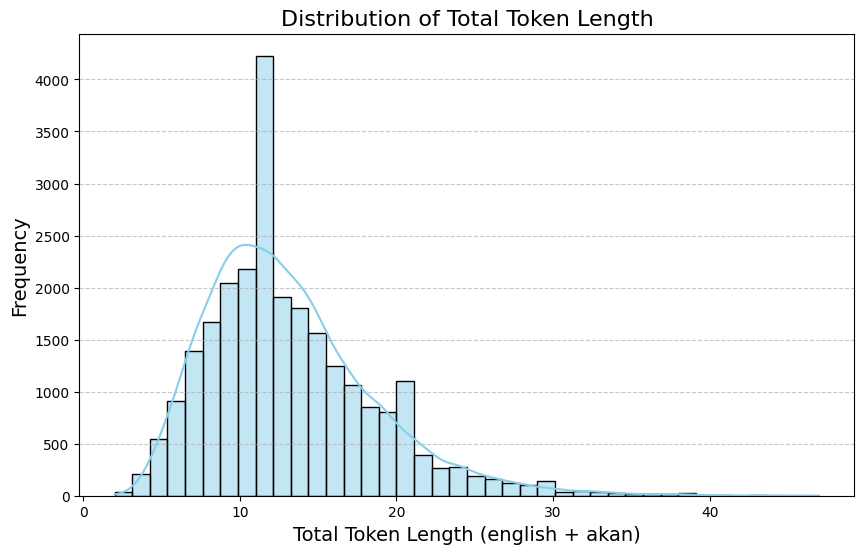

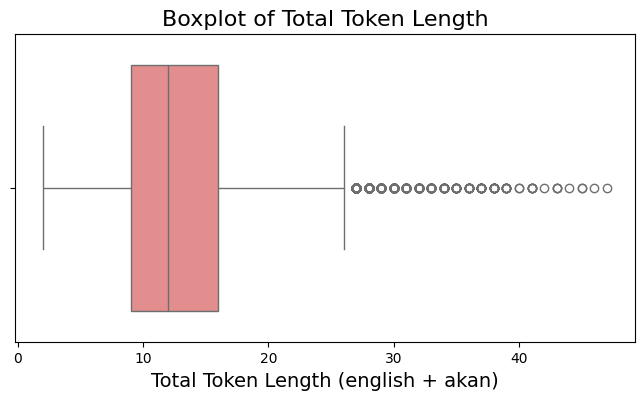

In [ ]:
# Plotting the distribution of total token length using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_sorted["total_token_length"], bins=40, kde=True, color="skyblue")
plt.title("Distribution of Total Token Length", fontsize=16)
plt.xlabel("Total Token Length (english + akan)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Boxplot to check the distribution of token lengths
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_sorted["total_token_length"], color="lightcoral")
plt.title("Boxplot of Total Token Length", fontsize=16)
plt.xlabel("Total Token Length (english + akan)", fontsize=14)
plt.show()

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, dataframe, pad_token=1):
        self.dataframe = dataframe
        self.pad_token = pad_token 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        english =  self.dataframe.iloc[idx]["english"]
        akan =  self.dataframe.iloc[idx]["akan"]
        english_tokens =  torch.tensor(self.dataframe.iloc[idx]["Padded_english"],  dtype=torch.long) 
        akan_tokens = torch.tensor(self.dataframe.iloc[idx]["Padded_akan"],  dtype=torch.long)  
        akan_target_tokens = torch.tensor(self.dataframe.iloc[idx]["Padded_akan_Target"],  dtype=torch.long)  

        def causal_mask(size):
              mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
              return mask == 0
        # Return the sequence and masks in a dictionary
        return {
            "english": english,
            "akan": akan,
            "english_token": english_tokens.clone(),
            "akan_token": akan_tokens.clone(),
            "akan_target": akan_target_tokens.clone(),
            "encoder_mask": (english_tokens != self.pad_token).unsqueeze(0).unsqueeze(0).int().clone(),
            "decoder_mask": (akan_tokens != self.pad_token).unsqueeze(0).int() & causal_mask(akan_tokens.size(0)).clone(),
        }

In [ ]:
dataset1 = TranslationDataset(level1)  
train_dataloader_1 = DataLoader(dataset1, batch_size = 16, shuffle=True) 
test_dataloader_1 = DataLoader(dataset1, batch_size=1, shuffle=True) 

dataset2 = TranslationDataset(level2) 
train_dataloader_2 = DataLoader(dataset2, batch_size = 16, shuffle=True) 
test_dataloader_2 = DataLoader(dataset2, batch_size=1, shuffle=True) 

dataset3 = TranslationDataset(level3)  
train_dataloader_3 = DataLoader(dataset3, batch_size = 16, shuffle=True) 
test_dataloader_3 = DataLoader(dataset3, batch_size=1, shuffle=True) 


for batch_idx, batch in enumerate(train_dataloader_3):
    print(f"Batch {batch_idx + 1}:")

    print(f"  english sequence: {batch['english']}")  
    print(f"  akan sequence: {batch['akan']}") 
    print(f"  english token shape: {batch['english_token'].shape}")  
    print(f"  akan token shape: {batch['akan_token'].shape}")  
    print(f"  akan target sequence shape: {batch['akan_target'].shape}") 
    print(f"  english pad mask shape: {batch['encoder_mask'].shape}") 
    print(f"  Combined akan mask shape: {batch['decoder_mask'].shape}") 
    break
    
# Iterate through batches
for batch_idx, batch in enumerate(test_dataloader_3):
    print(f"Batch {batch_idx + 1}:")

    # Check the shapes of each tensor in the batch
    print(f"  english sequence: {batch['english']}")  
    print(f"  akan sequence: {batch['akan']}") 
    print(f"  english token shape: {batch['english_token'].shape}") 
    print(f"  akan token shape: {batch['akan_token'].shape}") 
    print(f"  akan target sequence shape: {batch['akan_target'].shape}") 
    print(f"  english pad mask shape: {batch['encoder_mask'].shape}") 
    print(f"  Combined akan mask shape: {batch['decoder_mask'].shape}") 
    break

Batch 1:
  english sequence: ["I'll remember you forever.", 'Whoever comes will be welcome.', 'Asamoah vanished.', 'The dog likes that kind of food.', 'This contest is fixed.', "Asamoah should have invited Abena, but he didn't.", 'I saw him being scolded by his mother.', 'Why should I hire you?', 'Asamoah claimed he saw a UFO.', "There's something about Abena that makes her irresistible.", 'Am I on the right road?', "Asamoah doesn't like swimming in pools. He prefers swimming in lakes and rivers.", 'I needed this.', "I didn't ask.", 'You are always complaining.', 'Kwabena and I helped each other.']
  akan sequence: ['Me werɛ remfi wo da.', 'Obiara a ɔbɛba no, wobegye no fɛw so.', 'Asamoah yerae', 'ɔkraman no pɛ aduan a ɛte saa.', 'Wɔde akansi yi asi hɔ.', 'Esiane sɛ na anka ɛsɛ sɛ Yaso to nsa frɛ Abena nti, wamfrɛ no, nanso wanyɛ saa.', "Mihuu sɛ ne maame reka n'anim.", 'Deɛn nti na ɛsɛ sɛ mebɔ wo paa?', 'Bere a Asamoah kae sɛ wahu UFO bi.', 'Biribi wɔ hɔ a wɔfrɛ no Abena a enti ontumi

In [ ]:
print("Vocabulary:", len(akan_tokenizer.word_to_id))
print("Vocabulary:", len(english_tokenizer.word_to_id))

Vocabulary: 12315
Vocabulary: 13026


MODEL ARCHITECTURE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# src_vocab_size = 8100
# tgt_vocab_size = 15529
src_vocab_size = 13026
tgt_vocab_size = 12315
d_model = 64
n_heads = 8
d_ff = 512
n_enc_layers = 8
n_dec_layers = 8
dropout = 0.1

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttention(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
            # Applying softmax activation function
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculating attention scores
        x, self.attention_scores = MultiHeadSelfAttention.attention(query, key, value, mask, self.dropout)

        # Combine the heads together
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        return self.w_o(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.attn(x,x,x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.enc_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        self_attn_output = self.self_attn(x ,x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        enc_attn_output = self.enc_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(enc_attn_output))
        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    def forward(self, src, src_mask):
        x = self.embedding(src)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)

        return self.fc_out(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, n_heads, d_ff, n_enc_layers, n_dec_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, n_enc_layers, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, n_heads, d_ff, n_dec_layers, dropout)

    def forward(self, src, tgt, src_mask, tgt_mask):
        enc_output = self.encoder(src, src_mask)
        output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return output
    
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, n_heads, d_ff, n_enc_layers, n_dec_layers, dropout).to(device)

Using device: cpu


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) 

total_params = count_parameters(model)
print(f"Total model parameters: {total_params}") 

Total model parameters: 3878427


FOR TRAINING

In [ ]:
epochs = 100
lr = 10**-4

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx, eos_idx = 2, 3
    encoder_output = model.encoder(source.to(device), source_mask.to(device))
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    while decoder_input.size(1) < max_len:
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        out = model.decoder(decoder_input, encoder_output, source_mask, decoder_mask)
        next_word = torch.max(out[:, -1], dim=1)[1]
        if next_word == eos_idx: break
        decoder_input = torch.cat([decoder_input, next_word.view(1, 1).to(device)], dim=1)

    return decoder_input.squeeze(0)[1:]


def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, num_examples=1):
    model.to(device)
    model.eval()
    source_texts, expected, predicted = [], [], []
    try:
      console_width = os.get_terminal_size().columns
    except OSError:
      console_width = 80

    with torch.no_grad():
        for count, batch in enumerate(validation_ds, start=1):
            encoder_input, encoder_mask = batch["english_token"].to(device), batch["encoder_mask"].to(device)
            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            source_text = batch["english"][0]
            target_text = batch["akan"][0]
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())

            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            print_msg(f"{'SOURCE:':>12}{source_text}\n{'TARGET:':>12}{target_text}\n{'PREDICTED:':>12}{model_out_text}\n{'-'*console_width}")
            if count == num_examples: break

def train_model():

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    checkpoint_path = "model_path/"
   
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)))
        print("Model loaded from checkpoint.")
    else :
        print("Checkpoint not found. Training from scratch.")
    if device == 'cuda':
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
        
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, eps=1e-9)
    loss_fn = nn.CrossEntropyLoss(ignore_index= 1).to(device)

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        if epoch <= 10:
            print("Training with Level 1 Data")
            train_dataloader = train_dataloader_1
            test_dataloader = test_dataloader_1
        elif epoch > 10 and epoch <= 20:
            print("Training with Level 2 Data")
            train_dataloader = train_dataloader_2
            test_dataloader = test_dataloader_2
        elif epoch > 20: 
            print("Training with Level 3 Data")
            train_dataloader = train_dataloader_3
            test_dataloader = test_dataloader_3
        else:
            print("cant get the data")

        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch+1:02d}")
        for batch in batch_iterator:
            encoder_input = batch['english_token'].to(device)
            decoder_input = batch['akan_token'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            output = model(encoder_input, decoder_input, encoder_mask, decoder_mask)

            label = batch['akan_target'].to(device)
            # Flattening the output
            output_flat = output.view(-1, output.size(-1)) 
            # Flattening the label 
            label_flat = label.view(-1)  

            # Computing the loss 
            loss = loss_fn(output_flat, label_flat)
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        torch.save(model.state_dict(), "Model_Params.pth")
        run_validation(model, test_dataloader, english_tokenizer, akan_tokenizer, 24, device, lambda msg: batch_iterator.write(msg))


warnings.filterwarnings("ignore")
train_model()

Using device: cpu
Checkpoint not found. Training from scratch.
Training with Level 1 Data


Processing Epoch 01: 100%|██████████| 46/46 [00:11<00:00,  3.91it/s, loss=7.336]


     SOURCE:Be discreet.
     TARGET:Yɛ anifere.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 02: 100%|██████████| 46/46 [00:11<00:00,  3.86it/s, loss=6.756]


     SOURCE:Kwaku drives.
     TARGET:Kwaku ka kar.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 03: 100%|██████████| 46/46 [00:13<00:00,  3.33it/s, loss=6.499]


     SOURCE:He walks slowly.
     TARGET:Ɔnantew brɛoo.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 04: 100%|██████████| 46/46 [00:12<00:00,  3.76it/s, loss=6.033]


     SOURCE:Let me speak.
     TARGET:Ma menka.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 05: 100%|██████████| 46/46 [00:12<00:00,  3.79it/s, loss=5.806]


     SOURCE:We're home.
     TARGET:Yɛwɔ fie.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 06: 100%|██████████| 46/46 [00:12<00:00,  3.69it/s, loss=5.714]


     SOURCE:Stop fighting!
     TARGET:Gyae ɔko!
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 07: 100%|██████████| 46/46 [00:12<00:00,  3.66it/s, loss=5.604]


     SOURCE:I'm skinny.
     TARGET:Meyɛ teatea
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 08: 100%|██████████| 46/46 [00:12<00:00,  3.75it/s, loss=5.307]


     SOURCE:He dislikes me.
     TARGET:Ɔmpɛ m'asɛm.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 09: 100%|██████████| 46/46 [00:12<00:00,  3.57it/s, loss=4.976]


     SOURCE:It's not important.
     TARGET:Ɛho nhia.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 10: 100%|██████████| 46/46 [00:12<00:00,  3.64it/s, loss=4.764]


     SOURCE:They help us.
     TARGET:Ɛboa yɛn.
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 1 Data


Processing Epoch 11: 100%|██████████| 46/46 [00:11<00:00,  3.85it/s, loss=4.923]


     SOURCE:Are you sick?
     TARGET:Woyare?
  PREDICTED:
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 12: 100%|██████████| 1512/1512 [07:05<00:00,  3.56it/s, loss=5.605]


     SOURCE:The world's largest telescope is in the Canary Islands.
     TARGET:Afiri a wɔde hwɛ akyirikyiri ade sen biara wɔ wiase ne Canary Islands.
  PREDICTED:Ná no no no a na na na nea no no no mu.
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 13: 100%|██████████| 1512/1512 [06:41<00:00,  3.77it/s, loss=5.136]


     SOURCE:They often go on picnics by bicycle.
     TARGET:Mpɛn pii no, wɔde sakre na ɛkɔ akwamma.
  PREDICTED:Ná ɛyɛ me ho sɛ ɔyɛ no mu.
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 14: 100%|██████████| 1512/1512 [06:02<00:00,  4.17it/s, loss=4.990]


     SOURCE:He can't buy a car.
     TARGET:Ontumi ntɔ kar.
  PREDICTED:Ná ɛyɛ den bi a wɔde yɛ den
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 15: 100%|██████████| 1512/1512 [06:33<00:00,  3.84it/s, loss=4.238]


     SOURCE:He will be really pleased.
     TARGET:N'ani begye ankasa.
  PREDICTED:Ɔde ne ho yɛ den.
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 16: 100%|██████████| 1512/1512 [07:06<00:00,  3.54it/s, loss=3.888]


     SOURCE:You don't have to help me.
     TARGET:Enhia sɛ woboa me.
  PREDICTED:Ɛsɛ sɛ meyɛ me.
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 17: 100%|██████████| 1512/1512 [06:21<00:00,  3.96it/s, loss=4.529]


     SOURCE:My sister used to take care of the flower bed.
     TARGET:Ná me nuabea na ɔhwɛ nhwiren mpa no so.
  PREDICTED:Me maame papa ne ho sɛ mɛyɛ no mu no ho.
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 18: 100%|██████████| 1512/1512 [06:29<00:00,  3.88it/s, loss=4.313]


     SOURCE:What do you think made him break his promise?
     TARGET:Wususuw sɛ dɛn na ɛmaa odii ne bɔhyɛ so?
  PREDICTED:Wususuw sɛ nea na ɛsɛ sɛ woyɛ no yɛ den
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 19: 100%|██████████| 1512/1512 [06:27<00:00,  3.90it/s, loss=3.271]


     SOURCE:Asamoah always complains about what Aku does.
     TARGET:Sɛnea Asamoah ka nea Aku yɛ ho asɛm bere nyinaa no.
  PREDICTED:Asamoah de nea ɔyɛ nea ɔyɛ ho asɛm no ho yɛ den.
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 20: 100%|██████████| 1512/1512 [06:24<00:00,  3.93it/s, loss=5.424]


     SOURCE:If you want to talk, let's talk.
     TARGET:Sɛ wopɛ sɛ wo ne obi kasa a, ma wo kasa.
  PREDICTED:Sɛ wopɛ sɛ woyɛ adwuma a, anka w'ani gye ho
--------------------------------------------------------------------------------
Training with Level 2 Data


Processing Epoch 21: 100%|██████████| 1512/1512 [06:26<00:00,  3.91it/s, loss=3.422]


     SOURCE:Turn right there.
     TARGET:Kɔ hɔ ara.
  PREDICTED:Kɔ so ara yɛ hɔ.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 22: 100%|██████████| 1588/1588 [06:47<00:00,  3.90it/s, loss=3.480]


     SOURCE:Will it rain tomorrow? "I hope not.
     TARGET:So osu bɛtɔ ɔkyena? " Mebɔ mpae sɛ ma ntɔ
  PREDICTED:So ɛyɛ den ma no sɛ obi a ɛte saa a, fa so
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 23: 100%|██████████| 1588/1588 [07:07<00:00,  3.71it/s, loss=3.242]


     SOURCE:I don't know exactly.
     TARGET:Minnim dekode pɔtee.
  PREDICTED:Minnim baabi a etwa to
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 24: 100%|██████████| 1588/1588 [07:18<00:00,  3.62it/s, loss=3.083]


     SOURCE:I went to see his sister last week.
     TARGET:Dapɛn a etwaam no, mekɔɔ ne nuabea nkyɛn.
  PREDICTED:Mekɔɔ nsa kɔɔ baabi a etwaam no.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 25: 100%|██████████| 1588/1588 [07:08<00:00,  3.71it/s, loss=3.981]


     SOURCE:If you want my help, you'll have to ask for it.
     TARGET:Sɛ wopɛ me mmoa a, ɛsɛ sɛ wubisa.
  PREDICTED:Sɛ wopɛ sɛ woka a, anka ɛsɛ sɛ wudi
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 26: 100%|██████████| 1588/1588 [07:03<00:00,  3.75it/s, loss=3.460]


     SOURCE:Asamoah should have gone to the dentist yesterday.
     TARGET:Na anka ɛsɛ sɛ Asamoa kohu dɔketa a ɔhwɛ se no nnera.
  PREDICTED:Ná ɛsɛ sɛ Asamoah ka sɛ ɔyɛ abofra no ho asɛm kyerɛ me.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 27: 100%|██████████| 1588/1588 [07:12<00:00,  3.67it/s, loss=2.921]


     SOURCE:I do not know for certain what she is going to do.
     TARGET:Minnim nea ɔbɛyɛ ankasa.
  PREDICTED:Minnim nea ɛsɛ sɛ mihu nea ɛsɛ sɛ ɔyɛ saa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 28: 100%|██████████| 1588/1588 [07:15<00:00,  3.65it/s, loss=3.696]


     SOURCE:Osaka is the second largest city of Japan.
     TARGET:Saa kurow no ne Japan kuropɔn a ɛto so abien a ɛso sen biara.
  PREDICTED:Saa nhwiren no mu biara wɔ afe a ɛwɔ hɔ a ɛwɔ hɔ no mu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 29: 100%|██████████| 1588/1588 [07:07<00:00,  3.72it/s, loss=1.961]


     SOURCE:We're available.
     TARGET:Yebenya ho.
  PREDICTED:Yɛyɛ yɛn ho.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 30: 100%|██████████| 1588/1588 [07:10<00:00,  3.69it/s, loss=2.375]


     SOURCE:I decided to tell her that I love him.
     TARGET:Misii gyinae sɛ mɛka akyerɛ no sɛ medɔ no.
  PREDICTED:Mekɔɔ sɛ me ne no nyɛ saa bere a na minni no.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 31: 100%|██████████| 1588/1588 [07:08<00:00,  3.70it/s, loss=3.061]


     SOURCE:I can hear you loud and clear.
     TARGET:Mete wo nne yiye.
  PREDICTED:Mitumi gye wo ne wo yɛ den.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 32: 100%|██████████| 1588/1588 [07:14<00:00,  3.66it/s, loss=2.866]


     SOURCE:I'm a little busy now.
     TARGET:Seesei minni adagyew koraa.
  PREDICTED:Seesei minni adagyew koraa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 33: 100%|██████████| 1588/1588 [07:06<00:00,  3.72it/s, loss=2.542]


     SOURCE:There were many things that I didn't like about that movie.
     TARGET:Ná nneɛma pii wɔ hɔ a m'ani nnye ho wɔ sini no ho.
  PREDICTED:Ná nnipa pii wɔ hɔ a m'ani gye ho sɛ m'ani gye ho saa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 34: 100%|██████████| 1588/1588 [07:05<00:00,  3.73it/s, loss=2.091]


     SOURCE:The prince was changed into a tree by magic.
     TARGET:Wɔde aduru sesaa ɔhene ba no ma ɔbɛyɛɛ dua.
  PREDICTED:Ná nhwiren no yɛ ɔman bi a emu yɛ den ahorow no mu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 35: 100%|██████████| 1588/1588 [07:12<00:00,  3.67it/s, loss=2.061]


     SOURCE:We often hear people say that time flies.
     TARGET:Yɛtaa te sɛ nkurɔfo ka sɛ bere kɔ ntɛmntɛm.
  PREDICTED:Yɛtaa ka sɛ nkurɔfo ka saa bere no.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 36: 100%|██████████| 1588/1588 [07:22<00:00,  3.59it/s, loss=2.547]


     SOURCE:Do you know if she can speak English?
     TARGET:So wunim sɛ obetumi aka Engiresi kasa?
  PREDICTED:Sɛ wunim Franse kasa a, wunim Franse kasa?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 37: 100%|██████████| 1588/1588 [07:12<00:00,  3.67it/s, loss=1.632]


     SOURCE:I met the president himself.
     TARGET:Mihyiaa ɔmampanyin no ankasa.
  PREDICTED:Mihyiaa ɔmampanyin no bi.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 38: 100%|██████████| 1588/1588 [07:06<00:00,  3.72it/s, loss=2.088]


     SOURCE:Lots of old people are killed in traffic accidents every year.
     TARGET:Nnipa  pii na kar akwanhyia kunkum wɔn afe biara.
  PREDICTED:Nnipa pii na wɔwɔ kar akwanhyia no mu biara wɔ afe biara mu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 39: 100%|██████████| 1588/1588 [07:07<00:00,  3.72it/s, loss=1.876]


     SOURCE:I went back to my seat.
     TARGET:Mesan kɔɔ m'agua so.
  PREDICTED:Mekɔɔ me sakre no kɔɔ sukuu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 40: 100%|██████████| 1588/1588 [07:16<00:00,  3.64it/s, loss=2.110]


     SOURCE:The rumor may or may not be true.
     TARGET:Ebetumi aba sɛ nea wɔreka ho asɛm no yɛ nokware anaa ɛnyɛ nokware.
  PREDICTED:Ebetumi aba sɛ na sukyerɛmma ayɛ nokware anaa ɛnte saa?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 41: 100%|██████████| 1588/1588 [07:07<00:00,  3.71it/s, loss=2.724]


     SOURCE:Was it you that left the door open last night?
     TARGET:Wo na wufii ɔpon no mu anadwo a etwaam no?
  PREDICTED:So na wotee sɛ wubehu apontow no ase anadwo a etwaam no?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 42: 100%|██████████| 1588/1588 [07:10<00:00,  3.69it/s, loss=1.870]


     SOURCE:Here is a present for you in token of our appreciation.
     TARGET:Nea edidi so yi yɛ anisɔ a yɛwɔ ma no.
  PREDICTED:Afe a edi hɔ no, sukyerɛmma ayɛ den sɛ wode ma yɛn sɛ yɛbɔ no.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 43: 100%|██████████| 1588/1588 [07:06<00:00,  3.72it/s, loss=1.721]


     SOURCE:You are no longer a child.
     TARGET:Wonyɛ abofra bio.
  PREDICTED:Wo nni adagyew koraa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 44: 100%|██████████| 1588/1588 [07:04<00:00,  3.74it/s, loss=1.840]


     SOURCE:It was Asamoah who stabbed Abena.
     TARGET:Ɛyɛ Asamoah na ɔwɔɔ Abena sekan.
  PREDICTED:Ɛyɛ Asamoa wɔ Abena fie.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 45: 100%|██████████| 1588/1588 [07:28<00:00,  3.54it/s, loss=2.349] 


     SOURCE:Asamoah told me he doesn't want to work with you.
     TARGET:Sɛnea Asamoah ka kyerɛɛ me no, ɔmpɛ sɛ ɔne wo yɛ adwuma.
  PREDICTED:Asamoah ka kyerɛɛ me sɛ ɔne wo yɛ adwuma.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 46: 100%|██████████| 1588/1588 [07:06<00:00,  3.72it/s, loss=2.390]


     SOURCE:Science is very exciting.
     TARGET:Nyansahu yɛ anigye yiye.
  PREDICTED:Nyansahu yɛ duru paa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 47: 100%|██████████| 1588/1588 [07:09<00:00,  3.70it/s, loss=1.548]


     SOURCE:Who designed the White House?
     TARGET:Hena na ɔyɛɛ White Fie no?
  PREDICTED:Hena na ɔmaa nkonim wɔ keeki no mu?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 48: 100%|██████████| 1588/1588 [07:10<00:00,  3.68it/s, loss=1.699]


     SOURCE:The President desires peace, doesn't he?
     TARGET:Ɔmampanyin no pɛ asomdwoe, ɛnte saa?
  PREDICTED:Ɔmampanyin no pɛ asomdwoe, ɛnte saa?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 49: 100%|██████████| 1588/1588 [06:52<00:00,  3.85it/s, loss=2.081]


     SOURCE:She wants to attend the party.
     TARGET:Ɔpɛ sɛ ɔkɔ apontow no ase.
  PREDICTED:Ɔpɛ sɛ ɔkɔ apontow no ase.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 50: 100%|██████████| 1588/1588 [06:45<00:00,  3.92it/s, loss=1.848]


     SOURCE:I still have no idea what I'm going to say to Asamoah.
     TARGET:Ɛde besi nnɛ, minnim nea mɛka akyerɛ Asamoa.
  PREDICTED:Meda so ara te sɛ nea meka kyerɛ Asamoah.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 51: 100%|██████████| 1588/1588 [06:47<00:00,  3.90it/s, loss=2.011]


     SOURCE:I would like some fish.
     TARGET:Mepɛ mpataa kakra
  PREDICTED:Mepɛ mpataa kakra
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 52: 100%|██████████| 1588/1588 [06:54<00:00,  3.83it/s, loss=1.089]


     SOURCE:He was having lunch when I entered the room.
     TARGET:Bere a miduu dan no mu no, na ɔredidi awia.
  PREDICTED:Bere a miduu fie no, na merekɔ dan no mu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 53: 100%|██████████| 1588/1588 [06:58<00:00,  3.79it/s, loss=0.998]


     SOURCE:Abena is my older sister.
     TARGET:Abena yɛ me nuabea panyin.
  PREDICTED:Abena yɛ me nuabea panyin.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 54: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=0.901]


     SOURCE:Even though there were many cookies on the dish, I only ate three.
     TARGET:Ɛwom sɛ na kuukisi pii wɔ kyɛnsere no mu de, nanso midii abiesa pɛ.
  PREDICTED:Ɛwom sɛ na obiara de nkra pii wɔ kyɛnsere no mu a na mehuruw no mu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 55: 100%|██████████| 1588/1588 [06:54<00:00,  3.83it/s, loss=1.217]


     SOURCE:Abena said that she loved me, but I didn't believe her.
     TARGET:Abena kaa sɛ ɔdɔ me, nanso na minnye no nni.
  PREDICTED:Abena kae sɛ m'ani nnye ne ho sɛ mɛka nanso minnye no ase.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 56: 100%|██████████| 1588/1588 [06:49<00:00,  3.88it/s, loss=1.229]


     SOURCE:I hope we can make a difference.
     TARGET:Migye di sɛ yebetumi  ama nsensanee aba.
  PREDICTED:Migye di sɛ yebetumi ayɛ anigye.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 57: 100%|██████████| 1588/1588 [06:59<00:00,  3.79it/s, loss=1.211]


     SOURCE:You're the only person I know who is my age.
     TARGET:Wo nkutoo ne nipa a minim no sɛ m'atipɛnfo.
  PREDICTED:Wo nkutoo ne nipa a minim no sɛ m'atipɛnfo.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 58: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=0.736]


     SOURCE:It wasn't Asamoah who lit the campfire.
     TARGET:Ná ɛnyɛ te sɛ nea w'ani so atan no.
  PREDICTED:Ná ɛyɛ den sɛ wubu adwene a wowɔ sɔhwɛ no.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 59: 100%|██████████| 1588/1588 [06:52<00:00,  3.85it/s, loss=1.683]


     SOURCE:The United States borders Canada.
     TARGET:United States hye Canada.
  PREDICTED:United States tɔn wɔ Canada.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 60: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=1.449]


     SOURCE:Where did you get all that money from?
     TARGET:Ɛhe na wunyaa sika yi nyinaa fii?
  PREDICTED:Ɛhe na wunyaa sika yi nyinaa fii?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 61: 100%|██████████| 1588/1588 [06:55<00:00,  3.82it/s, loss=1.099]


     SOURCE:He promised to come, but he didn't come.
     TARGET:Ɔhyɛɛ bɔ sɛ ɔbɛba, nanso wamma.
  PREDICTED:Ɔhyɛɛ bɔ sɛ ɔbɛba, nanso wamma.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 62: 100%|██████████| 1588/1588 [06:55<00:00,  3.83it/s, loss=1.660]


     SOURCE:Asamoah slept on the bus.
     TARGET:Asamoah da wɔ bɔs no mu no.
  PREDICTED:Asamoah da wɔ bɔs no so.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 63: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=1.098]


     SOURCE:I'm sorry for breaking my promise.
     TARGET:Ɛyɛ me yaw sɛ madi me bɔhyɛ so.
  PREDICTED:Ɛyɛ me yaw sɛ madi me bɔhyɛ so.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 64: 100%|██████████| 1588/1588 [06:50<00:00,  3.86it/s, loss=1.176]


     SOURCE:This is the dictionary I told you about yesterday.
     TARGET:Eyi ne nsɛm asekyerɛ nhoma a meka kyerɛɛ wo bɛyɛ owigyinae.
  PREDICTED:Eyi ne nsɛm asekyerɛ nhoma a meka kyerɛɛ wo no bɛyɛ owigyinae.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 65: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=1.646]


     SOURCE:I usually get up at eight.
     TARGET:Metaa sɔre bɛyɛ baawɔtwe.
  PREDICTED:Metaa sɔre ntɛm ara.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 66: 100%|██████████| 1588/1588 [06:56<00:00,  3.81it/s, loss=0.926]


     SOURCE:The police observed the man enter the bank.
     TARGET:Polisifo no hui sɛ ɔbarima no akɔ hyɛ sikakorabea hɔ.
  PREDICTED:Polisifo no hui sɛ ɔbarima no kɔ sikakorabea hɔ ara.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 67: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=1.057]


     SOURCE:Asamoah was fired on Monday.
     TARGET:Woyii Asamoah adi dwoda.
  PREDICTED:Na Asamoa da hɔ Dwoda.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 68: 100%|██████████| 1588/1588 [06:50<00:00,  3.87it/s, loss=1.130]


     SOURCE:I dislike living in such a noisy place.
     TARGET:M'ani nnye ho sɛ mɛtra beae a ɛhɔ yɛ dede saa.
  PREDICTED:M'ani nnye ho sɛ mɛtra nea nkurɔfo wɔ ɛno ho.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 69: 100%|██████████| 1588/1588 [06:54<00:00,  3.83it/s, loss=1.291]


     SOURCE:The child threw a stone at the dog.
     TARGET:Abofra no tow ɔbo bɔɔ ɔkraman no.
  PREDICTED:Abofra no tow ɔbo bɔɔ ɔkraman no.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 70: 100%|██████████| 1588/1588 [06:48<00:00,  3.89it/s, loss=0.566]


     SOURCE:It's completely visible.
     TARGET:Wɔahu no yiye.
  PREDICTED:Wɔahu no yiye.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 71: 100%|██████████| 1588/1588 [07:02<00:00,  3.76it/s, loss=0.903]


     SOURCE:It's an inside joke.
     TARGET:Ɛyɛ aseresɛm bi a ɛwɔ yɛn mu.
  PREDICTED:Ɛyɛ aseresɛm bi a ɛyɛ hu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 72: 100%|██████████| 1588/1588 [06:52<00:00,  3.85it/s, loss=0.706]


     SOURCE:Scotland is famous for its woollen textiles.
     TARGET:Scotland agye din wɔ n'atade a wɔde nhwi ayɛ no mu.
  PREDICTED:Scotland agye din wɔ n'atade a wɔde nhwi ayɛ no mu.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 73: 100%|██████████| 1588/1588 [06:50<00:00,  3.86it/s, loss=0.760]


     SOURCE:Write your goals down on a sheet of paper.
     TARGET:Kyerɛw wo botae ahorow gu krataa so.
  PREDICTED:Kyerɛw wo botae ahorow bɔ nkɔmmɔ kakra.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 74: 100%|██████████| 1588/1588 [06:48<00:00,  3.88it/s, loss=0.719]


     SOURCE:My mother gets up the earliest every morning.
     TARGET:Anɔpa biara na me maame sɔre ntɛm.
  PREDICTED:Anɔpa biara na me maame sɔre ntɛm.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 75: 100%|██████████| 1588/1588 [06:57<00:00,  3.80it/s, loss=1.461]


     SOURCE:Kwabena will eventually need an operation.
     TARGET:Awiei koraa no, Kwabena behia oprehyɛn.
  PREDICTED:Awiei koraa no, Kwabena behia oprehyɛn.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 76: 100%|██████████| 1588/1588 [06:49<00:00,  3.88it/s, loss=0.765]


     SOURCE:Kwabena asked Abena about her family.
     TARGET:Kwabena bisaa Abena abusua ho asɛm.
  PREDICTED:Kwabena bisaa Abena abusua ho asɛm.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 77: 100%|██████████| 1588/1588 [06:50<00:00,  3.86it/s, loss=1.153]


     SOURCE:Maybe we should return to Boston.
     TARGET:Ebia ɛsɛ sɛ yɛsan kɔ Boston.
  PREDICTED:Ebia ɛsɛ sɛ yɛsan kɔ Boston.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 78: 100%|██████████| 1588/1588 [06:53<00:00,  3.84it/s, loss=1.027]


     SOURCE:Kwabena and Abena wanted to talk about old times.
     TARGET:Kwabena ne Abena pɛe sɛ wɔka mmere dedaw no ho asɛm.
  PREDICTED:Kwabena ne Abena pɛe sɛ wɔka mmere dedaw no ho asɛm.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 79: 100%|██████████| 1588/1588 [06:57<00:00,  3.80it/s, loss=0.557]


     SOURCE:I have a secret dream.
     TARGET:Mewɔ anidaso bi a emu yɛ den.
  PREDICTED:Mewɔ anidaso bi a emu yɛ den.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 80: 100%|██████████| 1588/1588 [06:49<00:00,  3.88it/s, loss=0.461]


     SOURCE:I'm very confused.
     TARGET:M'adwene atu afra paa.
  PREDICTED:M'adwene atu afra paa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 81: 100%|██████████| 1588/1588 [06:53<00:00,  3.84it/s, loss=1.371]


     SOURCE:Hi, my name is Pekka. What is your name?
     TARGET:Me din de Pekka, wo din de sɛn?
  PREDICTED:Me din de Pekka, wo din de sɛn?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 82: 100%|██████████| 1588/1588 [06:48<00:00,  3.88it/s, loss=0.212]


     SOURCE:I have no idea how it works.
     TARGET:Minnim sɛnea ɛyɛ adwuma fa.
  PREDICTED:Minnim sɛnea ɛyɛ adwuma fa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 83: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=0.538]


     SOURCE:He has a drug allergy.
     TARGET:Ɔwɔ aduru bi a etumi sa yare.
  PREDICTED:Ɔwɔ aduru bi a egyina so.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 84: 100%|██████████| 1588/1588 [06:57<00:00,  3.80it/s, loss=0.876]


     SOURCE:I hope you'll get well soon.
     TARGET:Migye di sɛ ɛrenkyɛ wo ho bɛtɔ wo.
  PREDICTED:Migye di sɛ ɛrenkyɛ wo ho bɛtɔ wo.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 85: 100%|██████████| 1588/1588 [06:52<00:00,  3.85it/s, loss=0.379]


     SOURCE:I can fix it.
     TARGET:Metumi asiesie.
  PREDICTED:Metumi asiesie.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 86: 100%|██████████| 1588/1588 [06:48<00:00,  3.89it/s, loss=0.474]


     SOURCE:The noise distracted him from studying.
     TARGET:Ná dede no mma ontumi nsua ade.
  PREDICTED:Ná dede no mma ontumi nsua ade.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 87: 100%|██████████| 1588/1588 [06:56<00:00,  3.82it/s, loss=0.518]


     SOURCE:I lost my sunglasses.
     TARGET:Mehweree me ahwehwɛniwa.
  PREDICTED:Mehweree me ahwehwɛniwa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 88: 100%|██████████| 1588/1588 [06:55<00:00,  3.82it/s, loss=0.527]


     SOURCE:Asamoah admitted that he murdered Esi.
     TARGET:Asamoah gye toom sɛ okum Esi.
  PREDICTED:Asamoah gye toom sɛ okum Esi.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 89: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=0.650]


     SOURCE:Asamoah doesn't want to spend the rest of his life in jail.
     TARGET:Asamoah mpɛ sɛ ɔda afiase ne nkwa nna nyinaa.
  PREDICTED:Asamoah mpɛ sɛ ɔda afiase ne nkwa nna nyinaa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 90: 100%|██████████| 1588/1588 [06:52<00:00,  3.85it/s, loss=0.904]


     SOURCE:I am very much obliged to you for your help.
     TARGET:Mede wo ka pa ara wɔ wo mmoa a wode maa me no ho
  PREDICTED:Ɛyɛ me asɛyɛde yiye sɛ wuyi me mmoa denneennen.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 91: 100%|██████████| 1588/1588 [07:02<00:00,  3.76it/s, loss=0.796]


     SOURCE:I'm pretty sure Kwabena won't do anything crazy.
     TARGET:Migye di paa sɛ Kwabena renyɛ biribiara a ɛbɔ dam.
  PREDICTED:Migye di sɛ Kwabena renyɛ biribiara a ɛsɛ sɛ ɔbɛka akyerɛ atoro biara.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 92: 100%|██████████| 1588/1588 [06:51<00:00,  3.86it/s, loss=1.054]


     SOURCE:I can't believe that she is older than my mother.
     TARGET:Mannye anni sɛ wanyin sen me maame.
  PREDICTED:Mannye anni sɛ wanyin sen me maame.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 93: 100%|██████████| 1588/1588 [06:38<00:00,  3.99it/s, loss=0.669]


     SOURCE:What has he done today?
     TARGET:Dɛn na wayɛ nnɛ?
  PREDICTED:Dɛn na wayɛ nnɛ?
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 94: 100%|██████████| 1588/1588 [06:37<00:00,  4.00it/s, loss=0.797]


     SOURCE:The bread's on the table.
     TARGET:paanoo no si ɔpon no so.
  PREDICTED:Adwuma no si ɔpon no so.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 95: 100%|██████████| 1588/1588 [06:36<00:00,  4.00it/s, loss=0.559]


     SOURCE:All I want now is a little sleep.
     TARGET:Nea mepɛ seesei ara ara ne nna kakra.
  PREDICTED:Nea mepɛ seesei ara ne nna kakra.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 96: 100%|██████████| 1588/1588 [06:35<00:00,  4.02it/s, loss=0.834]


     SOURCE:Asamoah'll go.
     TARGET:Bere a Yalah rekɔ no.
  PREDICTED:Bere a Yalah rekɔ no.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 97: 100%|██████████| 1588/1588 [06:41<00:00,  3.96it/s, loss=0.404]


     SOURCE:The transition won't be easy.
     TARGET:Nsakrae no renyɛ mmerɛw.
  PREDICTED:Nsakrae no renyɛ mmerɛw.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 98: 100%|██████████| 1588/1588 [06:35<00:00,  4.01it/s, loss=0.175]


     SOURCE:It's dangerous to play with fire.
     TARGET:Asiane wom sɛ wode ogya bedi agoru.
  PREDICTED:Ɛyɛ hu sɛ wode ogya bedi agoru.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 99: 100%|██████████| 1588/1588 [06:46<00:00,  3.90it/s, loss=0.976]


     SOURCE:She was advised by him to be more careful.
     TARGET:Otuu no fo sɛ ɔnhwɛ yiye paa.
  PREDICTED:Otuu no fo sɛ ɔrekɔ hɔ paa.
--------------------------------------------------------------------------------
Training with Level 3 Data


Processing Epoch 100: 100%|██████████| 1588/1588 [06:35<00:00,  4.01it/s, loss=0.651]


     SOURCE:I felt very lonely.
     TARGET:Na mayɛ ankonam pa ara.
  PREDICTED:Meyɛɛ basaa.
--------------------------------------------------------------------------------


FOR INFERENCE

In [ ]:
def causal_mask(size, device):
    mask = torch.triu(torch.ones((1, size, size), device=device), diagonal=1).int()
    return mask == 0

#greedy decoding for inference
def greedy_decode1(model, source, source_mask, max_len, device):
    sos_idx, eos_idx = 2, 3
    encoder_output = model.encoder(source, source_mask)
    decoder_input = torch.empty(1, 1, device=device).fill_(sos_idx).long()

    while decoder_input.size(1) < max_len:
        decoder_mask = causal_mask(decoder_input.size(1), device)
        out = model.decoder(decoder_input, encoder_output, source_mask, decoder_mask)
        next_word = torch.max(out[:, -1], dim=1)[1]
        if next_word.item() == eos_idx:
            break
        decoder_input = torch.cat([decoder_input, next_word.view(1, 1)], dim=1)

    return decoder_input.squeeze(0)[1:]

def run_validation1(model, encoder_input, encoder_mask, max_len, device):
    model.to(device)
    model.eval()
    predicted = []
    
    try:
        console_width = os.get_terminal_size().columns
    except OSError:
        console_width = 80

    with torch.no_grad():
        
        encoder_input = encoder_input.to(device)
        encoder_mask = encoder_mask.to(device)
        
        assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"
        model_out = greedy_decode1(model, encoder_input, encoder_mask, max_len, device)
    
        model_out_text = akan_tokenizer.decode(model_out.detach().cpu().numpy())
        predicted.append(model_out_text)

        print(f"{'PREDICTED : '}{model_out_text}")

sentence1 = "Kwaku got out of the hospital."
sentence = english_tokenizer.encode(sentence1)
sentence = pad_sequence_source(sentence, 20, cls_token=2, sep_token=3)
sentence = torch.tensor(sentence, dtype=torch.long).to(device)  
encoder_input = sentence.unsqueeze(0).to(device)  
encoder_mask = (sentence != 1).unsqueeze(0).unsqueeze(0).int().to(device) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("SOURCE    :",sentence1)
run_validation1(model, encoder_input, encoder_mask, 24, device)

SOURCE    : Kwaku got out of the hospital.
PREDICTED : Kwaku fii ayaresabea hɔ kɔe.


TAKING MODEL PARAMETERS FROM MEMORY TO A STANDALONE MODEL, READY FOR DEPLOYMENT

In [ ]:
# SAVING THE MODEL AND TOKENIZERS

import torch
import dill
import os

# 1. Save the model
def save_model(model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, "translation_model.pth")

    model_cpu = {k: v.cpu() for k, v in model.state_dict().items()}
    torch.save(model_cpu, model_path)
    print(f"Model saved to {model_path}")

# 2. Save the tokenizers
def save_tokenizers(akan_tokenizer, english_tokenizer, save_dir):
    os.makedirs(save_dir, exist_ok=True)
   
    # Save akan tokenizer
    akan_path = os.path.join(save_dir, "akan_tokenizer.pkl")
    with open(akan_path, 'wb') as f:
        ##saving with dill instead of pickle
        dill.dump(akan_tokenizer, f)
   
    # Saving english tokenizer
    english_path = os.path.join(save_dir, "english_tokenizer.pkl")
    with open(english_path, 'wb') as f:
        ##saving with dill instead of pickle
        dill.dump(english_tokenizer, f)
   
    print(f"Tokenizers saved to {save_dir}")

# Saving model configuration
def save_config(config, save_dir):
    """Save model configuration to disk."""
    os.makedirs(save_dir, exist_ok=True)
    config_path = os.path.join(save_dir, "model_config.pkl")
   
    with open(config_path, 'wb') as f:
        # pickle.dump(config, f)
        dill.dump(config, f)
   
    print(f"Configuration saved to {config_path}")

save_dir = "model_path/"

# Save model
save_model(model, save_dir)

# Save tokenizers
save_tokenizers(akan_tokenizer, english_tokenizer, save_dir)

# Save configuration
config = {
    "src_vocab_size": src_vocab_size,
    "tgt_vocab_size": tgt_vocab_size,
    "d_model": d_model,
    "n_heads": n_heads,
    "d_ff": d_ff,
    "n_enc_layers": n_enc_layers,
    "n_dec_layers": n_dec_layers,
    "dropout": dropout,
    "max_pad": max_pad,
    "special_tokens": special_tokens
}
save_config(config, save_dir)


# LOADING THE MODEL AND TOKENIZERS 
# ==================================================

import torch
import dill
import os
import math
import torch.nn as nn

# 1. Defining all the model components
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadSelfAttention.attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        return self.w_o(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.enc_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        enc_attn_output = self.enc_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(enc_attn_output))
        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    def forward(self, src, src_mask):
        x = self.embedding(src)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return self.fc_out(x)

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, n_heads, d_ff, n_enc_layers, n_dec_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_heads, d_ff, n_enc_layers, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, n_heads, d_ff, n_dec_layers, dropout)

    def forward(self, src, tgt, src_mask, tgt_mask):
        enc_output = self.encoder(src, src_mask)
        output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return output

# Loading configurations
def load_config(model_dir):
    config_path = os.path.join(model_dir, "model_config.pkl")
    with open(config_path, 'rb') as f:
        config = dill.load(f)
    return config

# Initializing and load model
def load_model(model_dir):
    config = load_config(model_dir)
   
    # Creating model with the initialized architecture
    model = Transformer(
        config["src_vocab_size"],
        config["tgt_vocab_size"],
        config["d_model"],
        config["n_heads"],
        config["d_ff"],
        config["n_enc_layers"],
        config["n_dec_layers"],
        config["dropout"]
    )
   
    # Loading model weights
    model_path = os.path.join(model_dir, "translation_model.pth")
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
   
    return model, config

# Loading tokenizers
def load_tokenizers(model_dir):
    # Load akan tokenizer
    akan_path = os.path.join(model_dir, "akan_tokenizer.pkl")
    with open(akan_path, 'rb') as f:
        akan_tokenizer = dill.load(f)
    # Load english tokenizer
    english_path = os.path.join(model_dir, "english_tokenizer.pkl")
    with open(english_path, 'rb') as f:
        english_tokenizer = dill.load(f)
   
    return english_tokenizer, akan_tokenizer

# Inference utility functions
def causal_mask(size, device):
    mask = torch.triu(torch.ones((1, size, size), device=device), diagonal=1).int()
    return mask == 0

def pad_sequence_source(tokens, max_len, cls_token=2, sep_token=3):
    padded_tokens = [cls_token] + tokens + [sep_token]
   
    if len(padded_tokens) < max_len:
        padded_tokens.extend([1] * (max_len - len(padded_tokens)))
    else:
        padded_tokens = padded_tokens[:max_len]
   
    return padded_tokens

def greedy_decode(model, source, source_mask, max_len, device):
    sos_idx, eos_idx = 2, 3
    encoder_output = model.encoder(source, source_mask)
    decoder_input = torch.empty(1, 1, device=device).fill_(sos_idx).long()

    while decoder_input.size(1) < max_len:
        decoder_mask = causal_mask(decoder_input.size(1), device)
        out = model.decoder(decoder_input, encoder_output, source_mask, decoder_mask)
        next_word = torch.max(out[:, -1], dim=1)[1]
        if next_word.item() == eos_idx:
            break
        decoder_input = torch.cat([decoder_input, next_word.view(1, 1)], dim=1)

    return decoder_input.squeeze(0)[1:]

# translation function
def translate(text, model, english_tokenizer, akan_tokenizer, max_len=24, device='cpu'):
    model.eval()
   
    # Tokenizing and padding input
    tokens = english_tokenizer.encode(text)
    padded_tokens = pad_sequence_source(tokens, max_len)
    source = torch.tensor(padded_tokens, dtype=torch.long).unsqueeze(0).to(device)
    source_mask = (source != 1).unsqueeze(1).unsqueeze(1).int().to(device)
   
    # Translation Generation
    with torch.no_grad():
        prediction = greedy_decode(model, source, source_mask, max_len, device)
        translated_text = akan_tokenizer.decode(prediction.cpu().numpy())
   
    return translated_text

# Usage
model_dir = "translation_model"  # Update this to your local path
device = torch.device('cpu')  # Force CPU usage

# Load everything
model, config = load_model(model_dir)
english_tokenizer, akan_tokenizer = load_tokenizers(model_dir)
model.to(device)

# Translate example text
text = "You are a good child"
translation = translate(text, model, english_tokenizer, akan_tokenizer, config["max_pad"], device)
print(f"English: {text}")
print(f"Akan: {translation}")


    

Model saved to translation_model/translation_model.pth
Tokenizers saved to translation_model/
Configuration saved to translation_model/model_config.pkl
English: You are a good child
Akan: Woyɛ abofra pa ara kwa.
